<a href="https://colab.research.google.com/github/smarulandas/Teoria_Aprendizaje_De_Maquina_-Machine_Learning-/blob/main/Conglomerados_3_TALLER_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conglomerados en Inteligencia Artificial**

## ¿Qué son los conglomerados?

En inteligencia artificial y aprendizaje automático, **conglomerados** (también llamados *clusters*) son grupos de datos que comparten características similares entre sí, pero que son diferentes de otros grupos.

## ¿Dónde se usan?

Los conglomerados se utilizan principalmente en técnicas de **aprendizaje no supervisado**, donde no se dispone de etiquetas previas. El algoritmo agrupa automáticamente los datos en función de su similitud.

## Ejemplos comunes de uso:
- Segmentación de clientes en marketing.
- Agrupamiento de imágenes similares.
- Análisis de patrones de comportamiento.
- Compresión y reducción de dimensionalidad de datos.

## Algoritmos de conglomerado populares:
- **K-Means**
- **DBSCAN**
- **Hierarchical Clustering**
- **Gaussian Mixture Models**

## Métricas de evaluación:
- Coeficiente de Silueta
- Índice de Davies-Bouldin
- Calinski-Harabasz Index

Los conglomerados permiten explorar estructuras ocultas en grandes volúmenes de datos, siendo clave en tareas de descubrimiento automático de conocimiento.


# Ejercicios

Para los siguientes puntos, utilizar la librería [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos estudiados, en caso de estar disponibles.

1. Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentación) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.


#**Solución**

#**1. Se descarga la imagen de Google Drive**

In [3]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

--2025-06-12 13:50:33--  https://docs.google.com/uc?export=download&confirm=&id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP
Resolving docs.google.com (docs.google.com)... 172.253.117.101, 172.253.117.138, 172.253.117.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download [following]
--2025-06-12 13:50:33--  https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6476 (6.3K) [image/jpeg]
Saving to: ‘tanjiro.jpeg’

tanjiro.jpeg        100%[===================>]   6.32K  --.-KB/s    in 0s

#**2. Se carga, recorta y muestra la imagen**

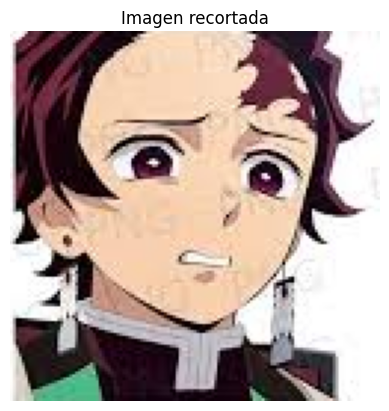

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

# Leer y recortar imagen
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]  # recorte visual

plt.imshow(image)
plt.title("Imagen recortada")
plt.axis('off')
plt.show()

#**3. Se Construye la matriz de características (R, G, B, x, y)**

---



In [5]:
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas x, y normalizadas
y_coords, x_coords = np.meshgrid(np.arange(r), np.arange(c), indexing='ij')
X_pos = np.stack([x_coords.ravel(), y_coords.ravel()], axis=1) / max(r, c)

# Combinar color + posición
X = np.concatenate([X_rgb, X_pos], axis=1)
print("Shape final de datos:", X.shape)


Shape final de datos: (15625, 5)


#**4. Kmeans para distintos valores de k**

   k     Inercia  Coef. Silueta
0  3  31547412.0       0.619762
1  5  10186788.0       0.655586
2  7   6774358.0       0.636863
3  9   5032201.0       0.589008


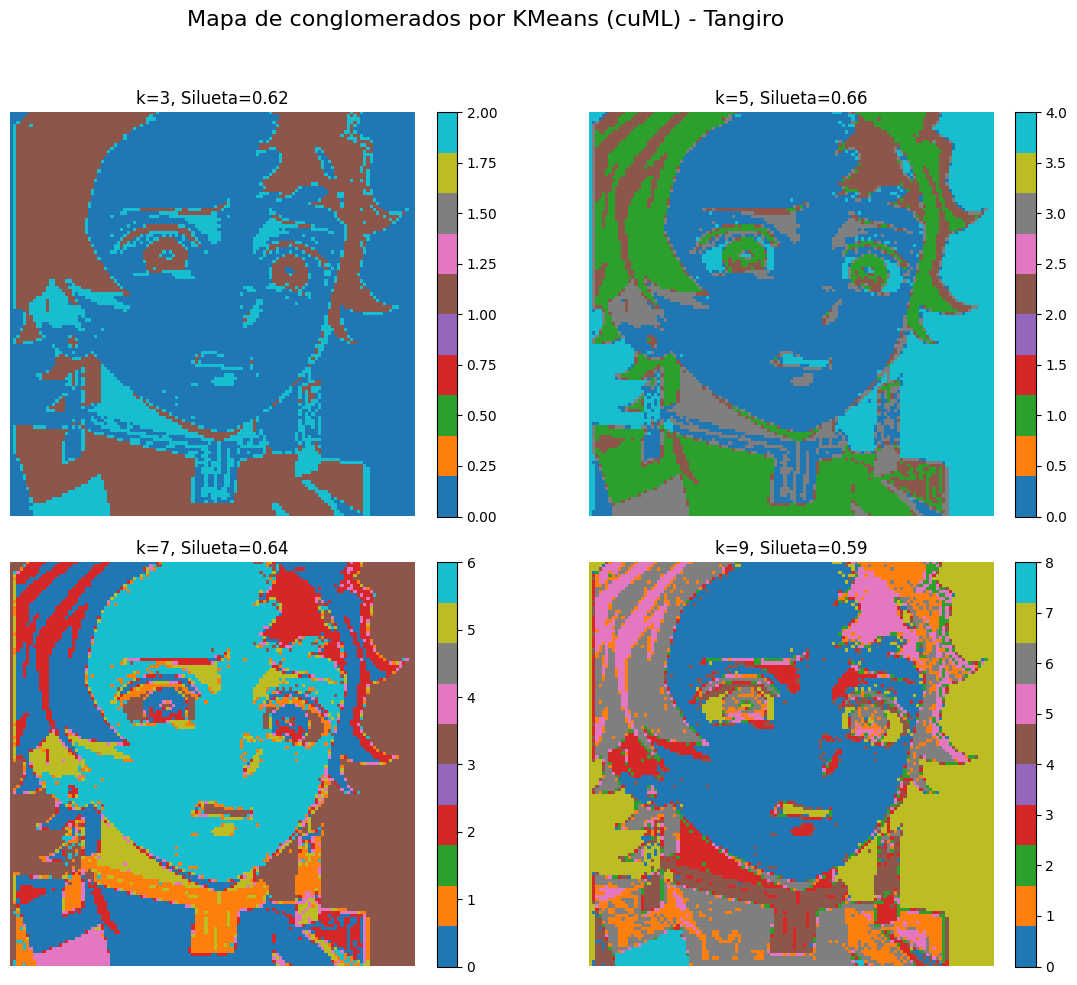

In [6]:
from cuml.cluster import KMeans as cuKMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Asegurar tipo float32 para cuML
X32 = X.astype(np.float32)

ks = [3, 5, 7, 9]
inertias = []
silhouettes = []
conglomerados = []

for k in ks:
    model = cuKMeans(n_clusters=k, random_state=0, n_init=10, output_type='numpy')
    labels = model.fit_predict(X32)

    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X32, labels))

    Ilabels = labels.reshape(r, c)
    conglomerados.append((Ilabels, k, silhouettes[-1]))

# === Tabla con métricas ===
df = pd.DataFrame({
    "k": ks,
    "Inercia": inertias,
    "Coef. Silueta": silhouettes
})
print(df)

# === Visualización en grid 2x2 con barra individual ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Mapa de conglomerados por KMeans (cuML) - Tangiro", fontsize=16)

for ax, (label_img, k, sil) in zip(axes.ravel(), conglomerados):
    im = ax.imshow(label_img, cmap='tab10')
    ax.set_title(f"k={k}, Silueta={sil:.2f}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#**4.1 Grafico de inercia (método del codo)**

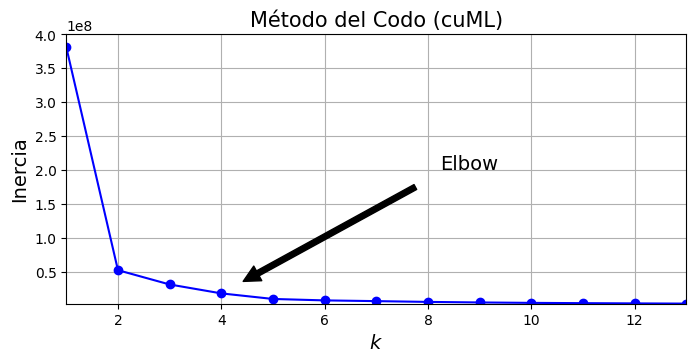

In [7]:
from cuml.cluster import KMeans as cuKMeans
import matplotlib.pyplot as plt
import numpy as np

# Asegurar tipo float32 para cuML
X32 = X.astype(np.float32)

# Calcular modelos para k = 1 a 13
kmeans_per_k = [
    cuKMeans(n_clusters=k, random_state=42, n_init=10, output_type='numpy').fit(X32)
    for k in range(1, 14)
]
inertias = [model.inertia_ for model in kmeans_per_k]

# Graficar el método del codo
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 14), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.title("Método del Codo (cuML)", fontsize=15)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.axis([1, 13, min(inertias)*0.95, max(inertias)*1.05])
plt.grid(True)
plt.show()


#**4.2 Gráficas de análisis de silueta para k=3,5,7,9**

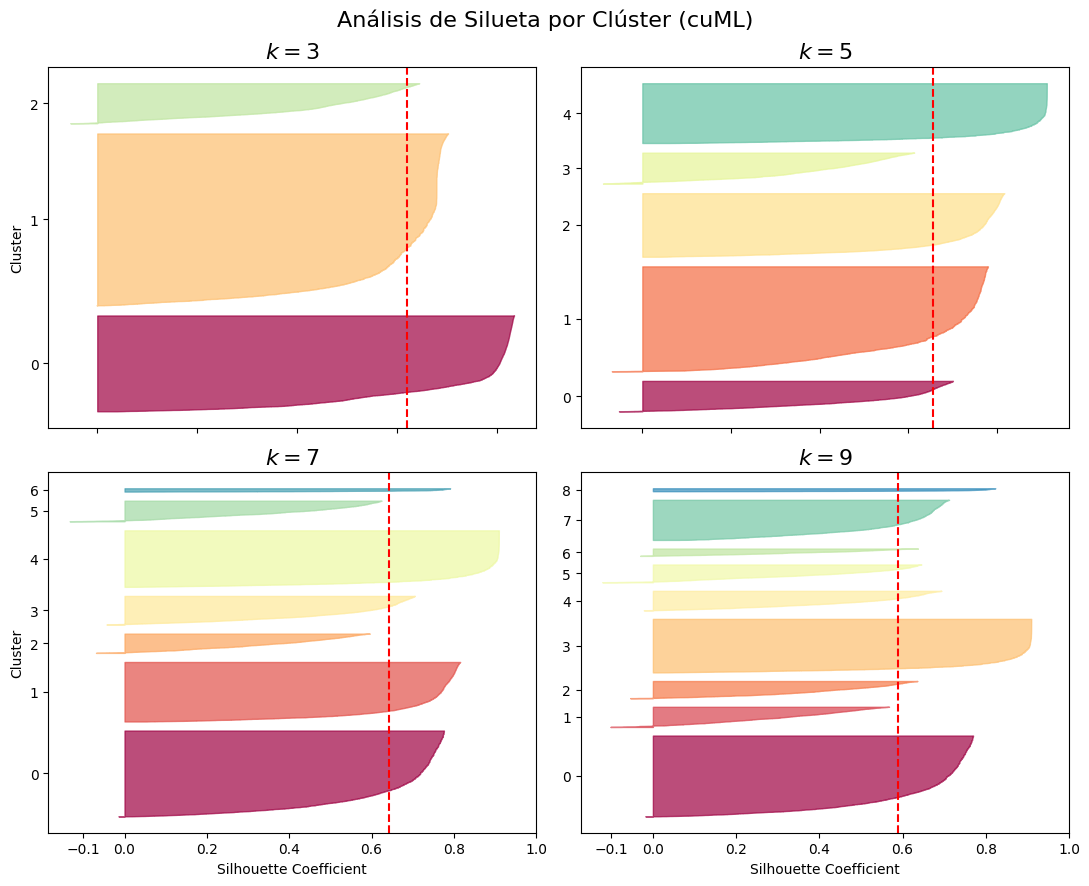

In [8]:
import numpy as np
import matplotlib as mpl
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from cuml.cluster import KMeans as cuKMeans
import matplotlib.pyplot as plt

# Asegurar que X esté en float32 para cuML
X32 = X.astype(np.float32)

# Calcular modelos para k = 1 a 13 con cuML
kmeans_per_k = [
    cuKMeans(n_clusters=k, random_state=42, n_init=10, output_type='numpy').fit(X32)
    for k in range(1, 14)
]

# Define the values of k you want to plot
ks_to_plot = [3, 5, 7, 9]

# === Visualización ===
plt.figure(figsize=(11, 9))

# Calculate silhouette scores only for the k values being plotted
silhouette_scores = [silhouette_score(X32, kmeans_per_k[k - 1].labels_) for k in ks_to_plot]

for i, k in enumerate(ks_to_plot):
    plt.subplot(2, 2, i + 1) # Adjust subplot index

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X32, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []

    for cluster_label in range(k):
        coeffs = silhouette_coefficients[y_pred == cluster_label]
        coeffs.sort()

        color = mpl.cm.Spectral(cluster_label / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    # Adjust x-axis labels for the bottom row
    if i in (2, 3): # Indices 2 and 3 correspond to k=7 and k=9 in ks_to_plot
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    # Adjust y-axis label for the left column
    if i in (0, 2): # Indices 0 and 2 correspond to k=3 and k=7
        plt.ylabel("Cluster")


    plt.axvline(x=silhouette_scores[i], color="red", linestyle="--") # Use silhouette_scores[i]
    plt.title(f"$k={k}$", fontsize=16)

plt.suptitle("Análisis de Silueta por Clúster (cuML)", fontsize=16)
plt.tight_layout()
plt.show()

#**4.3 Reconstrucción Tangiro**

In [8]:
from cuml.cluster import KMeans as cuKMeans
import matplotlib.pyplot as plt
import numpy as np

ks = [3, 5, 7, 9]
reconstrucciones = []

# Asegurar tipo float32
X32 = X.astype(np.float32)

for k in ks:
    model = cuKMeans(n_clusters=k, random_state=0, n_init=10, output_type='numpy')
    labels = model.fit_predict(X32)

    centroids = model.cluster_centers_[:, :3]  # solo los colores

    # Normalizar si los valores superan 1.0 (RGB en [0, 255])
    if centroids.max() > 1.0:
        centroids = centroids / 255.0

    seg_image = centroids[labels].reshape(r, c, 3)
    reconstrucciones.append((seg_image, k))

# Mostrar en grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Reconstrucción del Tangiro segmentado por cuML KMeans", fontsize=16)

for ax, (img, k) in zip(axes.ravel(), reconstrucciones):
    ax.imshow(img)
    ax.set_title(f"k={k}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#**5 Spectral Clustering para distintos valores de k**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   k  Coef. Silueta
0  3       0.257680
1  5       0.472687
2  7       0.345808
3  9       0.485264


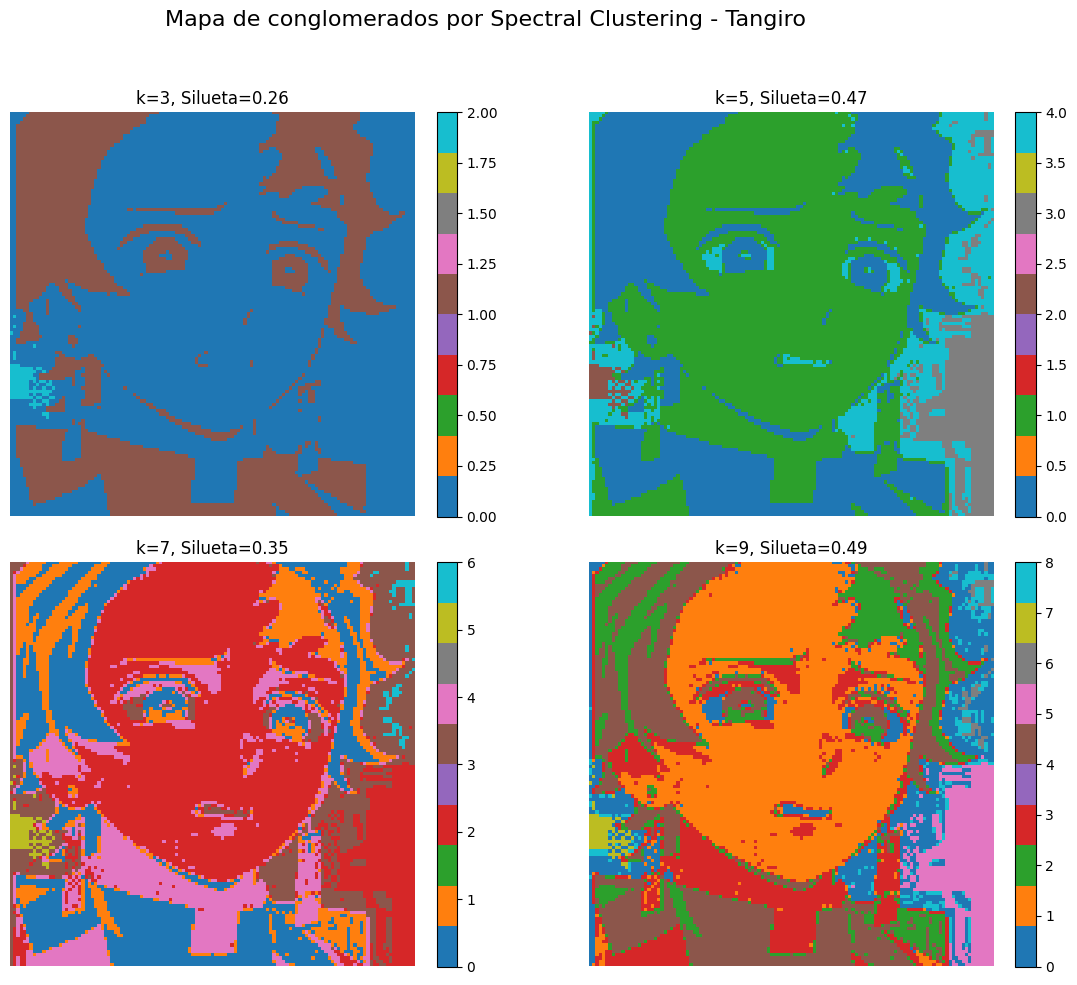

In [9]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ks = [3, 5, 7, 9]
silhouettes = []
conglomerados = []

# Asegurar tipo float64 (SpectralClustering requiere float64)
X64 = X.astype(np.float64)

for k in ks:
    model = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        assign_labels='kmeans',
        random_state=0,
        n_neighbors=20
    )
    labels = model.fit_predict(X64)
    silhouettes.append(silhouette_score(X64, labels))

    Ilabels = labels.reshape(r, c)
    conglomerados.append((Ilabels, k, silhouettes[-1]))

# === Tabla con métricas ===
df = pd.DataFrame({
    "k": ks,
    "Coef. Silueta": silhouettes
})
print(df)

# === Visualización en grid 2x2 con barra individual ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Mapa de conglomerados por Spectral Clustering - Tangiro", fontsize=16)

for ax, (label_img, k, sil) in zip(axes.ravel(), conglomerados):
    im = ax.imshow(label_img, cmap='tab10')
    ax.set_title(f"k={k}, Silueta={sil:.2f}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#**5.1 Método del Codo**
No aplicable a Spectral Clustering, ya que no tiene una métrica directa de inercia como KMeans.

#**5.2 Gráficas de análisis de silueta para k=3,5,7,9**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


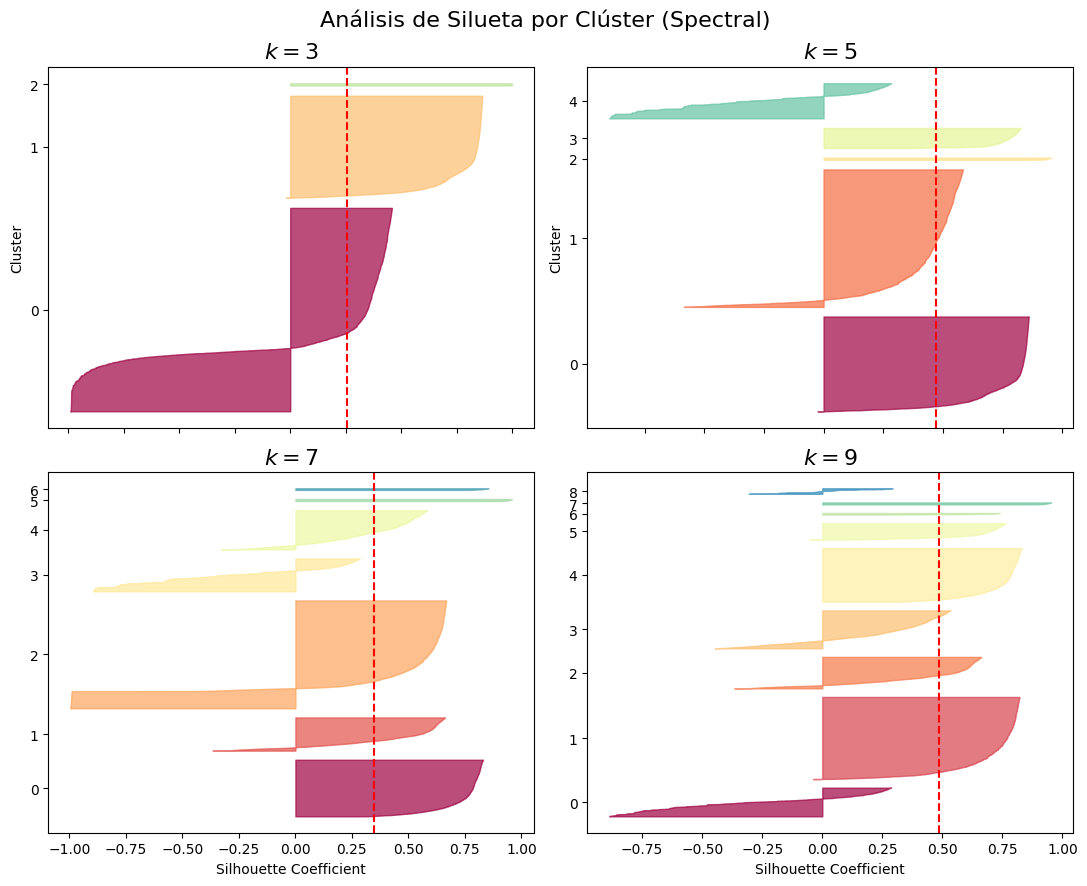

In [11]:
import numpy as np
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for idx, k in enumerate((3, 5, 7, 9)):
    model = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        assign_labels='kmeans',
        random_state=0,
        n_neighbors=20
    )
    y_pred = model.fit_predict(X64)
    silhouette_coefficients = silhouette_samples(X64, y_pred)
    score = silhouette_score(X64, y_pred)

    plt.subplot(2, 2, idx + 1)
    padding = len(X64) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (7, 9):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)

plt.suptitle("Análisis de Silueta por Clúster (Spectral)", fontsize=16)
plt.tight_layout()
plt.show()


#**5.3 Reconstrucción del tangiro con Spectral Clustering**


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


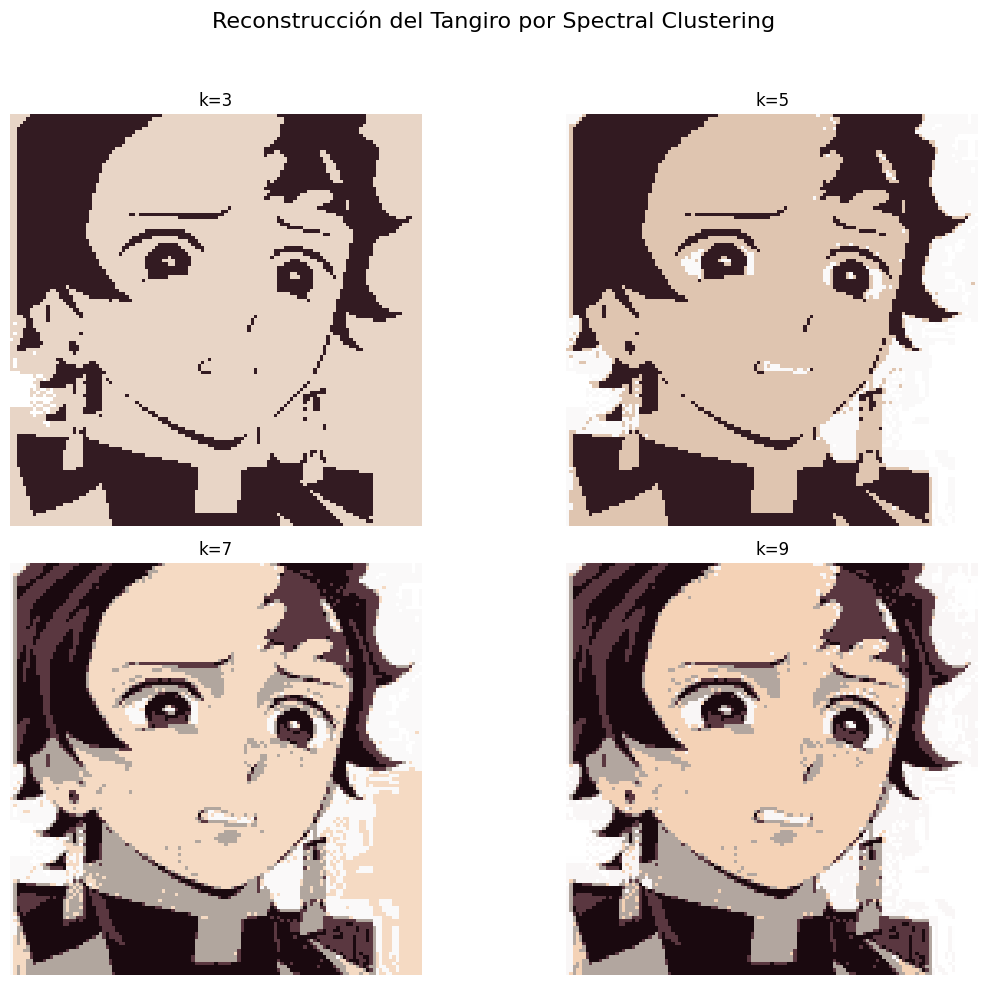

In [12]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np

ks = [3, 5, 7, 9]
reconstrucciones = []
X64 = X.astype(np.float64)

for k in ks:
    model = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        assign_labels='kmeans',
        random_state=0,
        n_neighbors=20
    )
    labels = model.fit_predict(X64)

    # Calcular color promedio por clúster
    centroids = []
    for lbl in range(k):
        mask = labels == lbl
        centroid = X[mask, :3].mean(axis=0)
        centroids.append(centroid)

    centroids = np.array(centroids)

    if centroids.max() > 1.0:
        centroids = centroids / 255.0

    seg_image = centroids[labels].reshape(r, c, 3)
    reconstrucciones.append((seg_image, k))

# Mostrar reconstrucciones
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Reconstrucción del Tangiro por Spectral Clustering", fontsize=16)

for ax, (img, k) in zip(axes.ravel(), reconstrucciones):
    ax.imshow(img)
    ax.set_title(f"k={k}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


 ## **Parte 2**

 Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP (ver guía [reducción de dimensión](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb))
 antes de generar las segmentaciones.

 #**KMeans con PCA y UMAP**

 #**1. Usar RAPIDS cuML para reducción a 2D**

In [13]:
from cuml.decomposition import PCA as cuPCA
from cuml import UMAP as cuUMAP
from cuml.cluster import KMeans as cuKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asegurar float32 para cuML
X32 = X.astype(np.float32)

# === Proyecciones ===
print("Reduciendo a 2D con PCA...")
X_pca2d = cuPCA(n_components=2).fit_transform(X32)

print("Reduciendo a 2D con UMAP...")
X_umap2d = cuUMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X32)


Reduciendo a 2D con PCA...
Reduciendo a 2D con UMAP...
[2025-06-12 13:55:05.361] [CUML] [info] build_algo set to brute_force_knn because random_state is given


#**2. Clustering con KMeans sobre cada proyección (PCA y UMAP)**

In [14]:
ks = [3, 5, 7, 9]

def clusterizar_y_mostrar(X_red, nombre_metodo):
    conglomerados = []
    silhouettes = []

    for k in ks:
        model = cuKMeans(n_clusters=k, random_state=0, n_init=10, output_type='numpy')
        labels = model.fit_predict(X_red)
        silhouettes.append(silhouette_score(X_red, labels))
        conglomerados.append((X_red, labels, k, silhouettes[-1]))

    # Mostrar resultados
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Clustering KMeans sobre {nombre_metodo} (2D)", fontsize=16)

    for ax, (X_, labels, k, sil) in zip(axes.ravel(), conglomerados):
        ax.scatter(X_[:, 0], X_[:, 1], c=labels, cmap='tab10', s=10)
        ax.set_title(f"k={k}, Silueta={sil:.2f}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Tabla con métricas
    df = pd.DataFrame({
        "k": ks,
        "Coef. Silueta": silhouettes
    })
    print(f"== Silhouette Scores para {nombre_metodo} ==")
    print(df)


#**3 3. Ejecutar para PCA y UMAP**

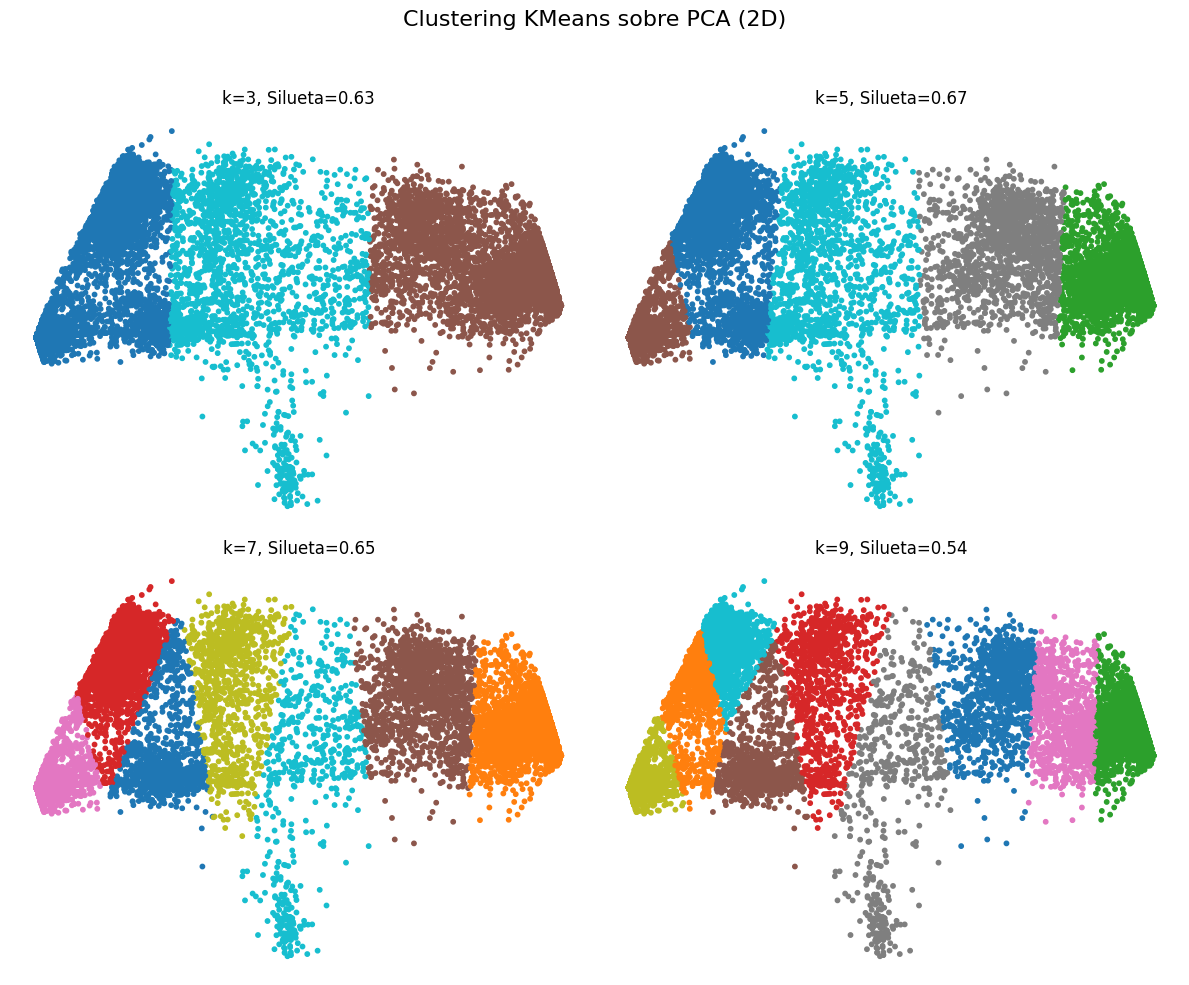

== Silhouette Scores para PCA ==
   k  Coef. Silueta
0  3       0.625430
1  5       0.667799
2  7       0.647703
3  9       0.540032


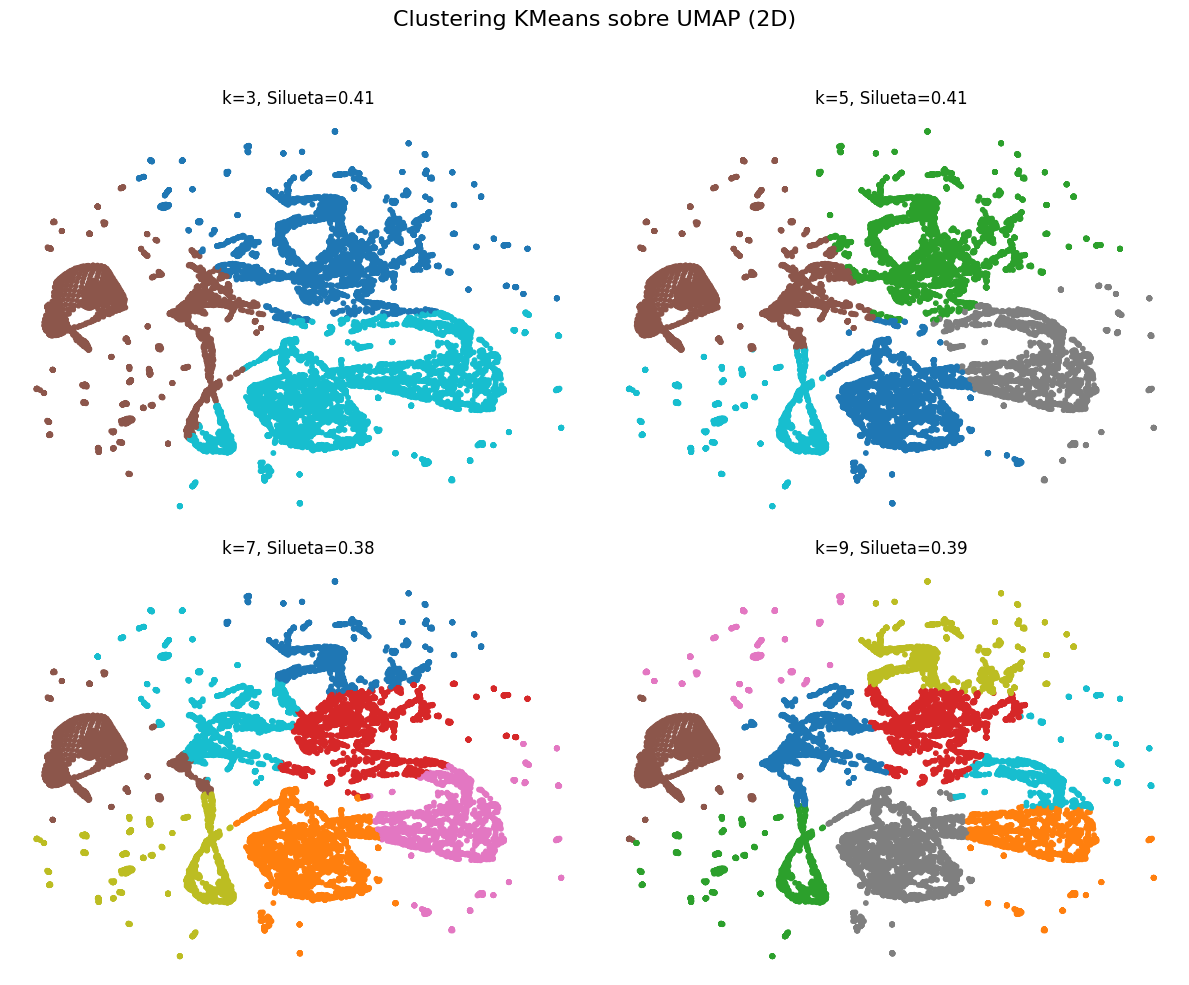

== Silhouette Scores para UMAP ==
   k  Coef. Silueta
0  3       0.413183
1  5       0.409230
2  7       0.376628
3  9       0.388321


In [15]:
clusterizar_y_mostrar(X_pca2d, "PCA")
clusterizar_y_mostrar(X_umap2d, "UMAP")


#**Spectral Clustering con proyección a 2D**

#**1 Reducción a 2D con RAPIDS (PCA y UMAP)**

#**3 Ejecutar para PCA y UMAP**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from cuml.decomposition import PCA as cuPCA
from cuml import UMAP as cuUMAP

# ==== 1. Submuestreo (reducimos a 2500 píxeles) ====
np.random.seed(42)
idx = np.random.choice(X.shape[0], size=2500, replace=False)
X_sub = X[idx].astype(np.float32)

# ==== 2. Reducción de dimensionalidad ====

# PCA 2D
print("Reducción con PCA...")
X_pca2d = cuPCA(n_components=2).fit_transform(X_sub)

# UMAP 2D
print("Reducción con UMAP...")
X_umap2d = cuUMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=0).fit_transform(X_sub)

# Convertir a float64 para sklearn
X_pca2d_64 = X_pca2d.astype(np.float64)
X_umap2d_64 = X_umap2d.astype(np.float64)


Reducción con PCA...
Reducción con UMAP...
[2025-06-12 13:55:38.292] [CUML] [info] build_algo set to brute_force_knn because random_state is given


#**2. Función de Clustering + visualización por método y proyección**

In [17]:
def aplicar_spectral(X_reducido, nombre):
    ks = [3, 5, 7, 9]
    resultados = []
    sil_scores = []

    for k in ks:
        model = SpectralClustering(
            n_clusters=k,
            affinity='nearest_neighbors',
            n_neighbors=100,
            assign_labels='kmeans',
            random_state=0
        )
        labels = model.fit_predict(X_reducido)
        score = silhouette_score(X_reducido, labels)
        resultados.append((X_reducido, labels, k, score))
        sil_scores.append(score)

    # === Visualización ===
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Spectral Clustering sobre {nombre} (2D)", fontsize=16)

    for ax, (X_, labels, k, sil) in zip(axes.ravel(), resultados):
        ax.scatter(X_[:, 0], X_[:, 1], c=labels, cmap='tab10', s=10)
        ax.set_title(f"k={k}, Silueta={sil:.2f}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # === Tabla resumen ===
    df = pd.DataFrame({
        "k": [3, 5, 7, 9],
        "Coef. Silueta": sil_scores
    })
    print(f"\n== Resultados para {nombre} ==")
    print(df)

#**3 Ejecutar para PCA y UMAP**

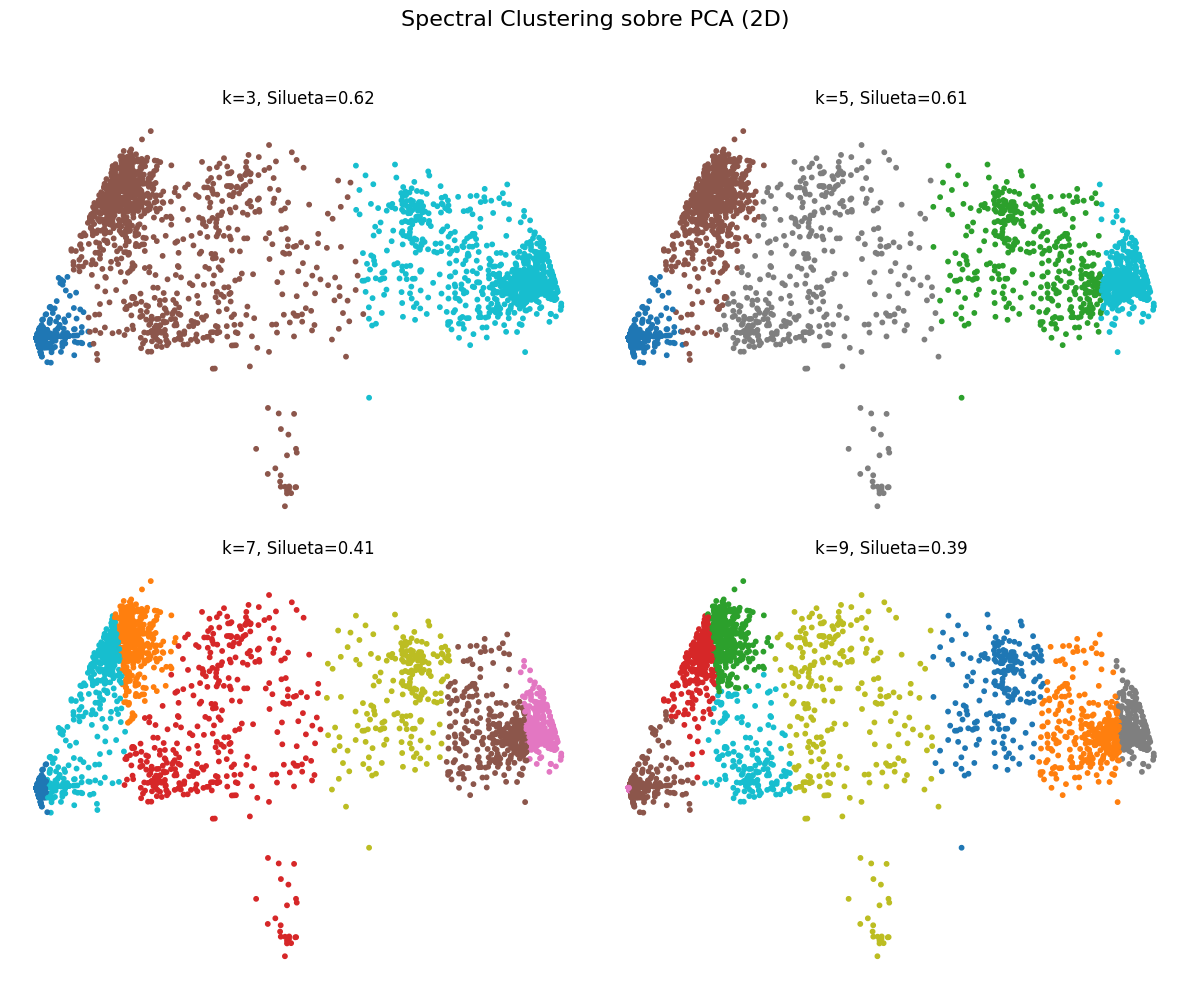


== Resultados para PCA ==
   k  Coef. Silueta
0  3       0.623853
1  5       0.609404
2  7       0.412699
3  9       0.387903


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


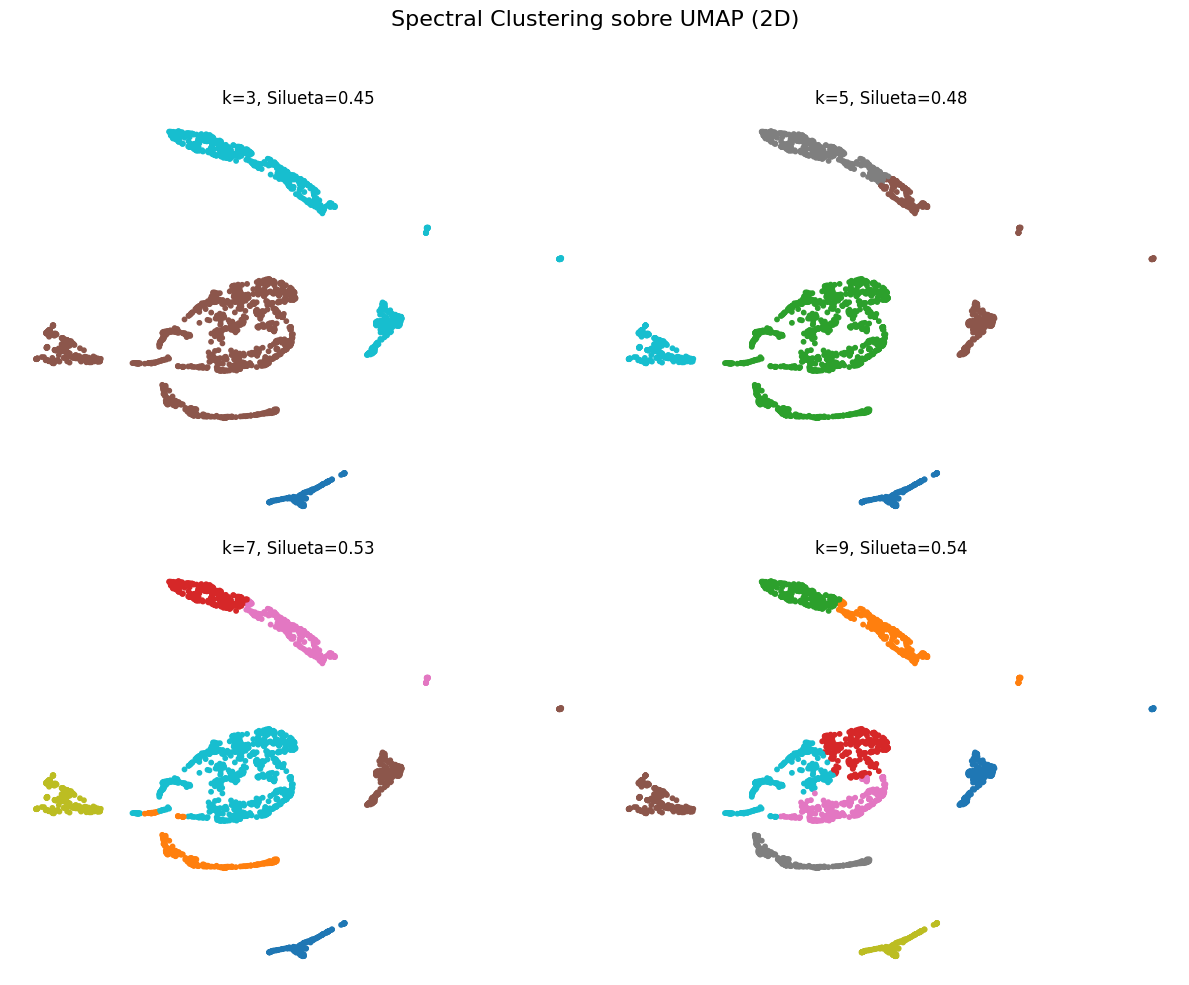


== Resultados para UMAP ==
   k  Coef. Silueta
0  3       0.448718
1  5       0.481072
2  7       0.534600
3  9       0.543808


In [18]:
aplicar_spectral(X_pca2d_64, "PCA")
aplicar_spectral(X_umap2d_64, "UMAP")